# **Predicting Loan Payback**
This notebook tackles Playground Series S5E10 – [https://www.kaggle.com/competitions/playground-series-s5e11](http://)

* EDA
* Preprocessing
* Feature engineering
* Modeling
* Ensemble ...
* Stacking ...


# 1. Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error
import lightgbm as lgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV, KFold


ModuleNotFoundError: No module named 'sklearn'

# 2. Import Train, Test, Submission_Sample Files

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train = pd.read_csv('/kaggle/input/playground-series-s5e11/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e11/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s5e11/sample_submission.csv')

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


In [ ]:
#Droping "id" column
train = train.drop("id", axis=1)
test = test.drop("id", axis=1)

# 3. EDA

In [ ]:
print(f"df Train shape {train.shape}")
print(f"df Test shape {test.shape}")

df Train shape (593994, 12)
df Test shape (254569, 11)


In [ ]:
pd.set_option('display.max_columns', None)
train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0



## Check Null and Duplicate Values


In [ ]:
print("Number of null value in Train DF : ",train.isna().sum().sum())
print("Number of null value in Test DF : ",test.isna().sum().sum())


Number of null value in Train DF :  0
Number of null value in Test DF :  0


In [ ]:
#Check Duplicate Rows
print("Number of Duplicated Row in Train DF : ", train.duplicated().sum())


Number of Duplicated Row in Train DF :  0


## Divide Numerical and Categorical Columns

In [ ]:
num_cols = train.select_dtypes(exclude= 'object').columns
print('Numerical columns :' ,num_cols ,"\n\n number of numerical columns:" ,len(num_cols))

print("="*100)
cat_cols = train.select_dtypes(include= 'object').columns
print('Categorical columns :' ,cat_cols,"\n\n number of categorical columns:" ,len(cat_cols) )

Numerical columns : Index(['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount',
       'interest_rate', 'loan_paid_back'],
      dtype='object') 

 number of numerical columns: 6
Categorical columns : Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object') 

 number of categorical columns: 6


## Numerical Features Analyse

In [ ]:
train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990
loan_paid_back,593994.0,0.798820,0.400883,0.000,1.000,1.000,1.000,1.000


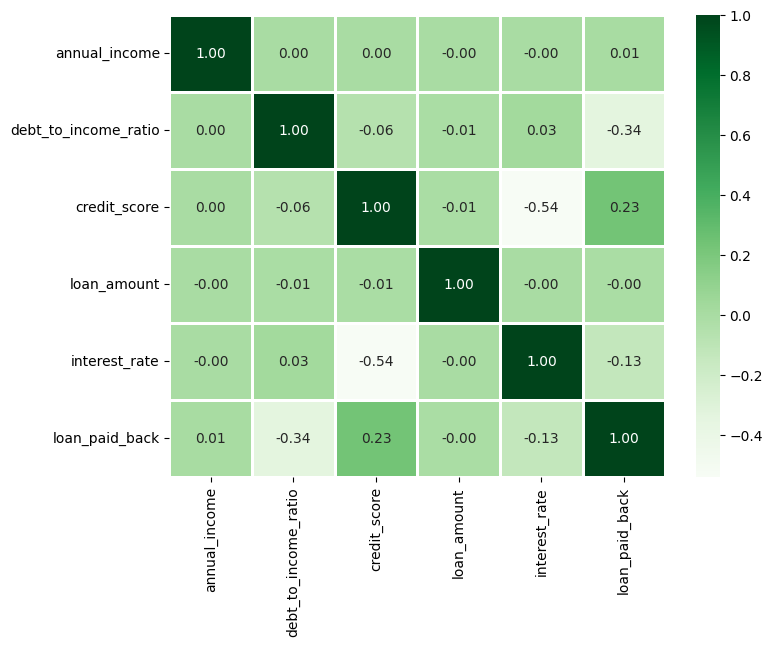

In [ ]:
# numerical features correlation
plt.figure(figsize=(8, 6))
correlation_matrix = train[num_cols ].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', 
            linewidths=1, cmap="Greens")
plt.show()

## Explore the Target Variable

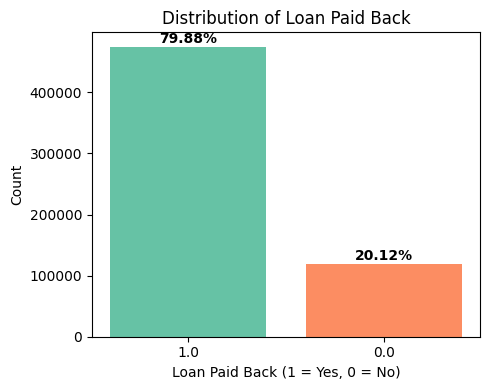

In [ ]:
# 1. Basic counts
target_counts = train['loan_paid_back'].value_counts()
# print("Count of each class:")
# print(target_counts)

# 2. Percentages
target_percent = train['loan_paid_back'].value_counts(normalize=True) * 100
# print("\nPercentage of each class:")
# print(target_percent.round(2))

# 3. Bar plot
# 1. Basic counts and percentages
target_counts = train['loan_paid_back'].value_counts()
target_percent = train['loan_paid_back'].value_counts(normalize=True) * 100

# 2. Plot
plt.figure(figsize=(5,4))
bars = plt.bar(target_counts.index.astype(str),
               target_counts.values,
               color=['#66c2a5','#fc8d62'])

# Add percentage labels on each bar
for bar in bars:
    height = bar.get_height()
    percent = (height / target_counts.sum()) * 100
    plt.text(bar.get_x() + bar.get_width()/2, height + 1000,  # adjust '1000' if scale differs
             f'{percent:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Distribution of Loan Paid Back')
plt.xlabel('Loan Paid Back (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

##  Class Imbalance

**This is a moderately imbalanced dataset — about 80/20 split.**

**That means:**

There are much fewer “default” cases (0.0).

A naive model that always predicts “1.0” (paid back) would already get ~80% accuracy — but terrible ROC-AUC because it can’t rank risk properly.

*So roughly 4 out of 5 loans are successfully repaid, and 1 out of 5 defaults.*

## Categorical Feature Analyse


=== GENDER ===
Value counts:
gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64

Average loan_paid_back (repayment rate):
gender
Female    0.802
Male      0.796
Other     0.795
Name: loan_paid_back, dtype: float64

Summary:
         Count  Repayment_Rate
gender                        
Female  306175        0.801708
Male    284091        0.795752
Other     3728        0.795333


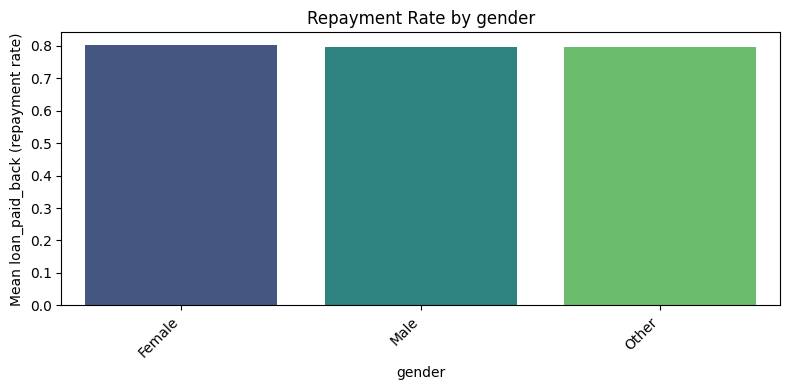


=== MARITAL_STATUS ===
Value counts:
marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64

Average loan_paid_back (repayment rate):
marital_status
Married     0.799
Single      0.799
Divorced    0.797
Widowed     0.790
Name: loan_paid_back, dtype: float64

Summary:
                 Count  Repayment_Rate
marital_status                        
Single          288843        0.798873
Married         277239        0.799144
Divorced         21312        0.796640
Widowed           6600        0.789848


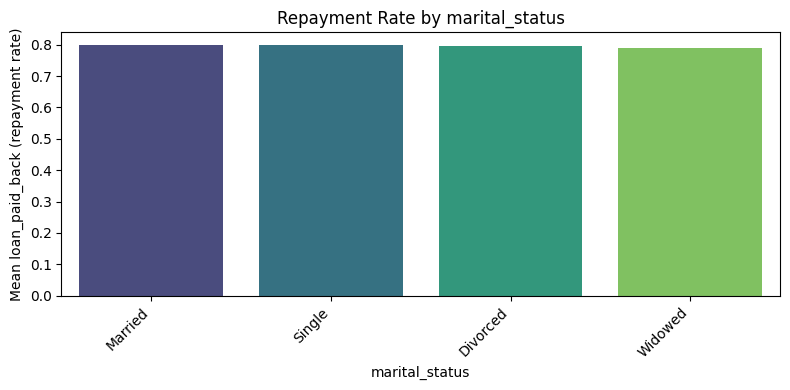


=== EDUCATION_LEVEL ===
Value counts:
education_level
Bachelor's     279606
High School    183592
Master's        93097
Other           26677
PhD             11022
Name: count, dtype: int64

Average loan_paid_back (repayment rate):
education_level
PhD            0.830
High School    0.810
Other          0.803
Master's       0.802
Bachelor's     0.789
Name: loan_paid_back, dtype: float64

Summary:
                  Count  Repayment_Rate
education_level                        
Bachelor's       279606        0.788892
High School      183592        0.809698
Master's          93097        0.802346
Other             26677        0.802789
PhD               11022        0.830067


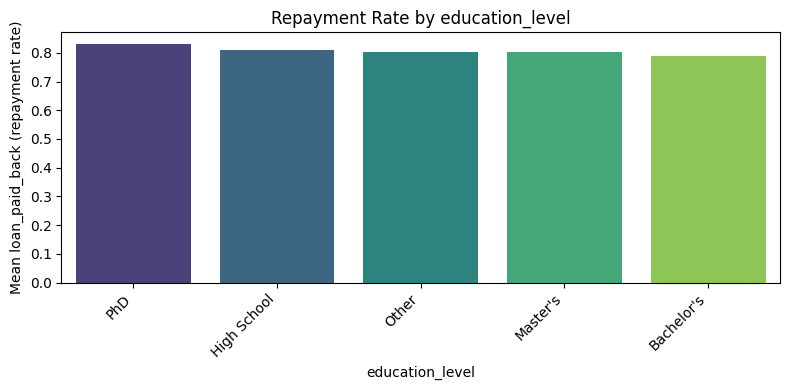


=== EMPLOYMENT_STATUS ===
Value counts:
employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64

Average loan_paid_back (repayment rate):
employment_status
Retired          0.997
Self-employed    0.898
Employed         0.894
Student          0.264
Unemployed       0.078
Name: loan_paid_back, dtype: float64

Summary:
                    Count  Repayment_Rate
employment_status                        
Employed           450645        0.894145
Unemployed          62485        0.077619
Self-employed       52480        0.898457
Retired             16453        0.997204
Student             11931        0.263515


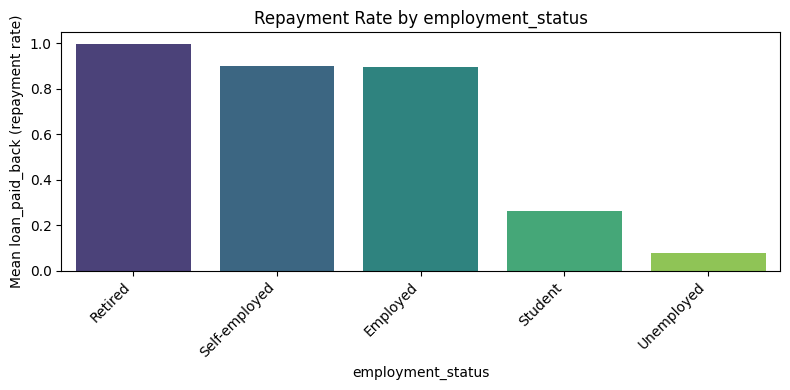


=== LOAN_PURPOSE ===
Value counts:
loan_purpose
Debt consolidation    324695
Other                  63874
Car                    58108
Home                   44118
Education              36641
Business               35303
Medical                22806
Vacation                8449
Name: count, dtype: int64

Average loan_paid_back (repayment rate):
loan_purpose
Home                  0.823
Business              0.813
Other                 0.802
Car                   0.801
Debt consolidation    0.797
Vacation              0.796
Medical               0.778
Education             0.777
Name: loan_paid_back, dtype: float64

Summary:
                     Count  Repayment_Rate
loan_purpose                              
Debt consolidation  324695        0.796911
Other                63874        0.802377
Car                  58108        0.800630
Home                 44118        0.823224
Education            36641        0.777053
Business             35303        0.813104
Medical              22

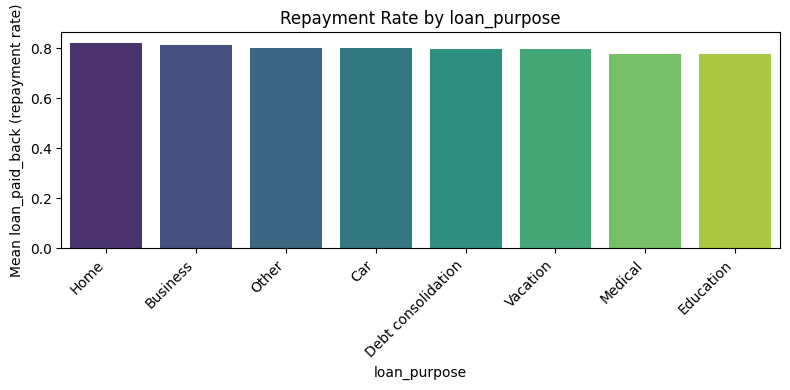


=== GRADE_SUBGRADE ===
Value counts:
grade_subgrade
C3    58695
C4    55957
C2    54443
C1    53363
C5    53317
D1    37029
D3    36694
D4    35097
D2    34432
D5    32101
B2    15167
B1    14344
B5    13937
B3    13926
B4    13877
E4     8036
E3     7075
E1     6891
E2     6372
E5     6084
F5     5947
F4     5535
F1     5534
F2     5203
F3     5082
A5     2471
A3     2066
A2     2018
A4     1701
A1     1600
Name: count, dtype: int64

Average loan_paid_back (repayment rate):
grade_subgrade
A4    0.957
A3    0.955
A2    0.953
A1    0.952
A5    0.945
B3    0.940
B2    0.937
B5    0.934
B4    0.932
B1    0.916
C1    0.860
C2    0.851
C5    0.846
C4    0.844
C3    0.836
D1    0.732
D2    0.721
D4    0.715
D5    0.713
D3    0.696
E5    0.669
E2    0.663
E1    0.652
E4    0.650
E3    0.642
F5    0.639
F4    0.637
F1    0.625
F2    0.618
F3    0.604
Name: loan_paid_back, dtype: float64

Summary:
                Count  Repayment_Rate
grade_subgrade                       
C3              58695

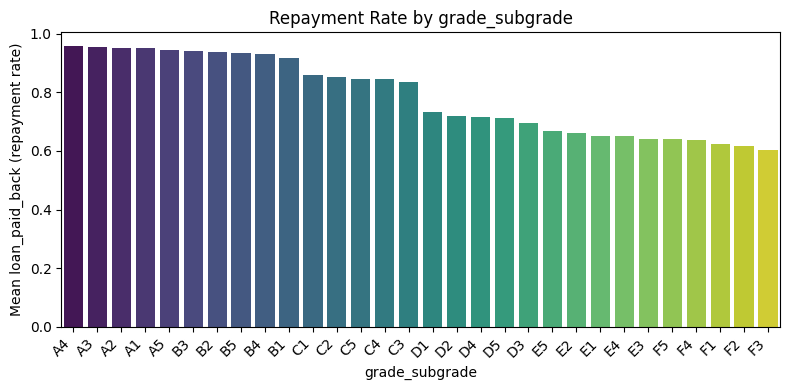

In [ ]:
# List your categorical columns



for col in cat_cols:
    print(f"\n=== {col.upper()} ===")
    
    # Frequency table
    freq = train[col].value_counts(dropna=False)
    print("Value counts:")
    print(freq)
    
    # Repayment rate (mean of target per category)
    repayment_rate = train.groupby(col)['loan_paid_back'].mean().sort_values(ascending=False)
    print("\nAverage loan_paid_back (repayment rate):")
    print(repayment_rate.round(3))
    
    # Combine both for easy reference
    summary = pd.concat([freq, repayment_rate], axis=1)
    summary.columns = ['Count', 'Repayment_Rate']
    print("\nSummary:")
    print(summary)
    
    # --- Visualization ---
    plt.figure(figsize=(8,4))
    
    # Bar for repayment rate (target mean)
    sns.barplot(
        x=repayment_rate.index,
        y=repayment_rate.values,
        palette="viridis"
    )
    plt.title(f'Repayment Rate by {col}')
    plt.ylabel('Mean loan_paid_back (repayment rate)')
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 4. Preprocessing
going to start with tree-based models (LightGBM, XGBoost, CatBoost).
label encoding works fine.

In [ ]:
X = train.drop(columns='loan_paid_back')
y = train['loan_paid_back']

In [ ]:
# Apply label encoding

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    test[col] = le.transform(test[col])


In [ ]:
se = StandardScaler()

# 5. Modeling

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

lgb = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(lgb, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print("CV AUC:", scores.mean(), "+/-", scores.std())

CV AUC: 0.9213470485621954 +/- 0.0007245691286616781


In [ ]:
lgb.fit(X,y)
lgb_pred = lgb.predict(test)

[LightGBM] [Info] Number of positive: 474494, number of negative: 119500
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1329
[LightGBM] [Info] Number of data points in the train set: 593994, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.798820 -> initscore=1.378933
[LightGBM] [Info] Start training from score 1.378933


In [ ]:
sub['loan_paid_back'] = lgb_pred

sub.to_csv('submission.csv', index=False)

sub.head()



,id,loan_paid_back
0,593994,1.0
1,593995,1.0
2,593996,1.0
3,593997,1.0
4,593998,1.0
